In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive")
os.chdir("/content/drive/MyDrive/ECE590_FinalProject")
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ECE590_FinalProject


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Mar 25 03:55:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import numpy as np
import _pickle as cPickle
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import warnings
import os, random
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from models import CNN
from models import RNN
from attacks import gradient_wrt_data

from utilities import process_data
from utilities import train_test_split
from utilities import evaluate_model
from utilities import evaluate_accuracy
from utilities import *

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
seed = 5
np.random.seed(seed)
torch.manual_seed(seed)
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current Device: ", device)
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Current Device:  cuda
Tesla P100-PCIE-16GB


In [ ]:
filename = "RML2016.10b.dat"
snrs, mods, X, labels = process_data(filename)

In [ ]:
print(type(snrs))
print(type(mods))
print(type(X))
print(type(labels))
print(snrs.shape)
print(len(mods))
print(X.shape)
print(len(labels))

<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.ndarray'>
<class 'list'>
(10,)
10
(600000, 2, 128)
600000


In [ ]:
curr_model = "RNN"

subsample = 1
# subsample = 2
# subsample = 4
# subsample = 8

In [ ]:
x_train0, x_test0, y_train, y_test, test_labels, test_idx = train_test_split(X, labels, mods, 
                                                    NN = curr_model)

#####################################################################
x_train = x_train0[:,:,::subsample]
x_test = x_test0[:,:,::subsample]

#####################################################################

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([480000, 2, 128])
torch.Size([120000, 2, 128])
torch.Size([480000])
torch.Size([120000])


In [ ]:
if curr_model == "RNN" :
    batch_size = 64
    if subsample == 1 : 
        model = RNN(input_size = 128).to(device = device)
        model_checkpoint = "RNN_base.pt"
    if subsample == 2 :
        model = RNN(input_size = 64).to(device = device)
        model_checkpoint = "RNN_base_sub12.pt"
    if subsample == 4 :
        model = RNN(input_size = 32).to(device = device)
        model_checkpoint = "RNN_base_sub14.pt"
    if subsample == 8 :
        model = RNN(input_size = 16).to(device = device)
        model_checkpoint = "RNN_base_sub18.pt"

num_epochs = 100
criterion  = nn.CrossEntropyLoss()
optimizer  = optim.Adam(model.parameters(), lr = 0.001)

train_dataset = TensorDataset(x_train, y_train.type(torch.LongTensor))
test_dataset  = TensorDataset(x_test,  y_test.type(torch.LongTensor))

TrainLoader = DataLoader(train_dataset, batch_size = batch_size, 
                         shuffle = False)
TestLoader  = DataLoader(test_dataset,  batch_size = batch_size, 
                         shuffle = False)

In [ ]:
##############################################################

In [ ]:
num_epochs   = 100
best_val_acc = 0.
criterion    = nn.CrossEntropyLoss()
optimizer    = optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(num_epochs) :
    model.train()
    train_epoch_loss = 0.
    train_epoch_acc  = 0.
    for batch_idx, (data, labels) in enumerate(TrainLoader) :
        data   = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss    = criterion(outputs, labels)
        acc     = evaluate_accuracy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_epoch_loss += loss.item()
        train_epoch_acc  += acc.item()
    
    with torch.no_grad() :
        model.eval()
        val_epoch_loss = 0.
        val_epoch_acc  = 0.
        
        for X_val_batch, y_val_batch in TestLoader :
            X_val_batch = X_val_batch.to(device)
            y_val_batch = y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
            
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc  = evaluate_accuracy(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc  += val_acc.item()
    
    avg_train_loss = float(train_epoch_loss) / len(TrainLoader)
    avg_train_acc  = float(train_epoch_acc) / len(TrainLoader)
    avg_val_loss   = float(val_epoch_loss) / len(TestLoader)
    avg_val_acc    = float(val_epoch_acc) / len(TestLoader)
    
    print(f'Epoch {epoch+1}: | Train Acc: {avg_train_acc:.3f} | Test Acc: {avg_val_acc:.3f}')
    
    if avg_val_acc > best_val_acc :
        print("Saving Model Checkpoint......")
        best_val_acc = avg_val_acc
        torch.save(model.state_dict(), model_checkpoint)

print("Training Complete!")

Epoch 1: | Train Acc: 28.774 | Test Acc: 30.662
Saving Model Checkpoint......
Epoch 2: | Train Acc: 32.232 | Test Acc: 35.151
Saving Model Checkpoint......
Epoch 3: | Train Acc: 36.229 | Test Acc: 37.587
Saving Model Checkpoint......
Epoch 4: | Train Acc: 38.608 | Test Acc: 40.170
Saving Model Checkpoint......
Epoch 5: | Train Acc: 40.683 | Test Acc: 41.754
Saving Model Checkpoint......
Epoch 6: | Train Acc: 42.277 | Test Acc: 43.525
Saving Model Checkpoint......
Epoch 7: | Train Acc: 43.866 | Test Acc: 44.869
Saving Model Checkpoint......
Epoch 8: | Train Acc: 45.749 | Test Acc: 46.549
Saving Model Checkpoint......
Epoch 9: | Train Acc: 47.574 | Test Acc: 48.355
Saving Model Checkpoint......
Epoch 10: | Train Acc: 49.549 | Test Acc: 50.344
Saving Model Checkpoint......
Epoch 11: | Train Acc: 51.209 | Test Acc: 52.212
Saving Model Checkpoint......
Epoch 12: | Train Acc: 52.749 | Test Acc: 53.470
Saving Model Checkpoint......
Epoch 13: | Train Acc: 54.101 | Test Acc: 54.715
Saving Model

In [ ]:
##############################################################

In [ ]:
rnn_net1 = RNN()
rnn_net2 = RNN(input_size=64)
rnn_net4 = RNN(input_size=32)
rnn_net8 = RNN(input_size=16)
rnn_net1.load_state_dict(torch.load("RNN_base.pt"))
rnn_net2.load_state_dict(torch.load("RNN_base_sub12.pt"))
rnn_net4.load_state_dict(torch.load("RNN_base_sub14.pt"))
rnn_net8.load_state_dict(torch.load("RNN_base_sub18.pt"))
rnn_net1 = rnn_net1.to(device)
rnn_net2 = rnn_net2.to(device)
rnn_net4 = rnn_net4.to(device)
rnn_net8 = rnn_net8.to(device)

In [ ]:
rnn_acc, rnn_loss, y_preds = evaluate_model(rnn_net1, TestLoader, device)
print("RNN_base Accuracy = %.4f" % rnn_acc)

RNN_base Accuracy = 0.7443


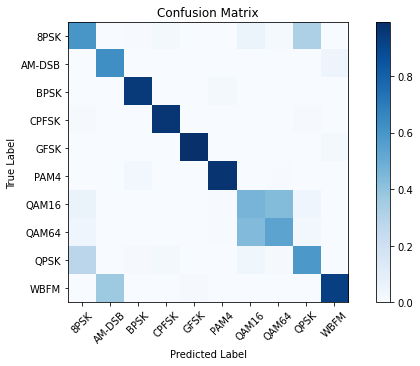

In [ ]:
plot_confusion_matrix(y_tests = y_test.cpu().numpy(), 
                      y_preds = y_preds, mods = mods)

In [ ]:
def predict_wrt_snr (model, y, device) :
    with torch.no_grad() :
        y = y.to(device = device)
        prediction = model(y)
        _, predicted_class = torch.max(prediction, dim = 1)
        return predicted_class.cpu().numpy()

def plot_snr_accuracy (model, x_test, labels,
                       test_labels, test_idx, snrs, mods, device) :
    acc = {}
    for snr in snrs :
        test_SNRs = list(map(lambda x: labels[x][1], test_idx))
        test_X_i = x_test[np.where(np.array(test_SNRs) == snr)]
        test_Y_i = test_labels[np.where(np.array(test_SNRs) == snr)]
        test_Y_i_hat = predict_wrt_snr(model, test_X_i, device)
        cm = confusion_matrix(test_Y_i, test_Y_i_hat)
        cofnorm = np.zeros([len(mods), len(mods)])
        for i in range(len(mods)) :
            cofnorm[i, :] = cm[i, :] / np.sum(cm[i, :])
        cor = np.sum(np.diag(cm))
        ncor = np.sum(cm) - cor
        acc[snr] = 1.0 * cor / (cor + ncor)

    # plt.plot(snrs, list(map(lambda x: 100 * acc[x], snrs)))
    # plt.grid()
    # plt.xticks(np.arange(0, 22, 2))
    # plt.xlabel("Signal to Noise Ratio (SNR)")
    # plt.ylabel("Classification Accuracy (%)")
    return acc

In [ ]:
x_train2, x_test2 = x_train0[:,:,::2], x_test0[:,:,::2]
x_train4, x_test4 = x_train0[:,:,::4], x_test0[:,:,::4]
x_train8, x_test8 = x_train0[:,:,::8], x_test0[:,:,::8]
acc_dict1 = plot_snr_accuracy(rnn_net1, x_test0, labels, test_labels, test_idx, snrs, mods, device)
acc_dict2 = plot_snr_accuracy(rnn_net2, x_test2, labels, test_labels, test_idx, snrs, mods, device)
acc_dict4 = plot_snr_accuracy(rnn_net4, x_test4, labels, test_labels, test_idx, snrs, mods, device)
acc_dict8 = plot_snr_accuracy(rnn_net8, x_test8, labels, test_labels, test_idx, snrs, mods, device)

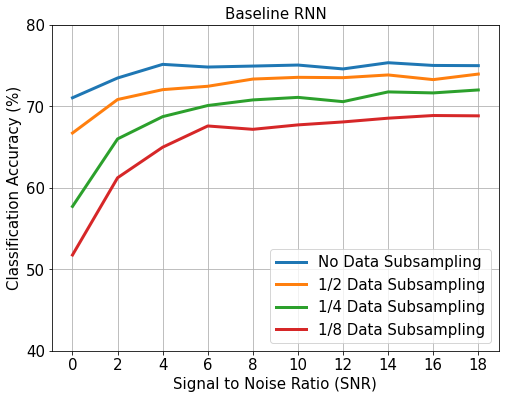

In [ ]:
figure, axis = plt.subplots()
axis.plot(snrs, list(map(lambda x: 100 * acc_dict1[x], snrs)), label = "No Data Subsampling", linewidth = 3)
axis.plot(snrs, list(map(lambda x: 100 * acc_dict2[x], snrs)), label = "1/2 Data Subsampling", linewidth = 3)
axis.plot(snrs, list(map(lambda x: 100 * acc_dict4[x], snrs)), label = "1/4 Data Subsampling", linewidth = 3)
axis.plot(snrs, list(map(lambda x: 100 * acc_dict8[x], snrs)), label = "1/8 Data Subsampling", linewidth = 3)
axis.set_xlabel("Signal to Noise Ratio (SNR)", fontsize = 15)
axis.set_ylabel("Classification Accuracy (%)", fontsize = 15)
axis.set_title("Baseline RNN", fontsize = 15)
axis.grid()
figure.set_size_inches(8, 6)
plt.xticks(snrs, fontsize = 15)
plt.yticks(np.array([40, 50, 60, 70, 80]), fontsize = 15)
plt.legend(loc = "lower right", fontsize = 15)
plt.show()